#### Library Imports


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib_inline.backend_inline as backend_inline
from torchsummary import summary

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

#### Data Import and Data Normalization


In [2]:
# Import Dataset
data = np.loadtxt("../Datasets/mnist_train_small.csv", delimiter=",")

# Extract data and labels
labels = data[:, 0]
data = data[:, 1:]
print("Data shape:", data.shape, "\nLabels shape:", labels.shape)

# Data normalization
dataNorm = data / np.max(data)

# Reshape the data to 2D
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)

# Print data final shape
print("Data final shape:", dataNorm.shape)

Data shape: (20000, 784) 
Labels shape: (20000,)
Data final shape: (20000, 1, 28, 28)


#### Create Train/Test groups using dataloaders


In [ ]:
# Step 1: Convert data into tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Step 2: Train and Test split
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labelsT, test_size=0.1
)

# Step 3: Convert data into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: Create DataLoaders for Train and Test sets
batch_size = 32
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    shuffle=False,
    drop_last=False,
    generator=torch.Generator(device=device),
)

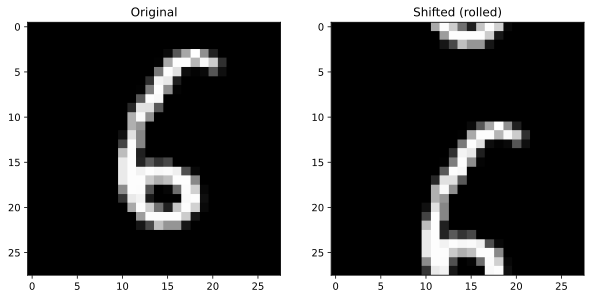

In [8]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_loader.dataset.tensors[0][0, :]
# tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp, 8, dims=1)


# now show them both
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(torch.squeeze(tmp.cpu()), cmap="gray")
ax[0].set_title("Original")

ax[1].imshow(torch.squeeze(tmpS.cpu()), cmap="gray")
ax[1].set_title("Shifted (rolled)")

plt.show()

In [11]:
# Now let's shift all the images in test set
for i in range(test_loader.dataset.tensors[0].shape[0]):
    image = test_loader.dataset.tensors[0][i, :]

    # Reshape the image
    randroll = np.random.randint(-20, 11)
    image = torch.roll(image, randroll, dims=1)

    # Convert it back to vector
    test_loader.dataset.tensors[0][i, :] = image

# Now let's shift all the images in train set
for i in range(train_loader.dataset.tensors[0].shape[0]):
    image = train_loader.dataset.tensors[0][i, :]

    # Reshape the image
    randroll = np.random.randint(-20, 11)
    image = torch.roll(image, randroll, dims=1)

    # Convert it back to vector
    train_loader.dataset.tensors[0][i, :] = image

#### Create Deep Learning Model


In [23]:
# Define a function to create a CNN model using class
def create_cnn_model(printToggle=False):
    class MNIST_CNN_Model(nn.Module):

        def __init__(self, printToggle):
            super().__init__()

            ### convolution layers
            self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
            # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

            self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
            # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

            # compute the number of units in FClayer (number of outputs of conv2)
            expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
            expectSize = 20*int(expectSize**2)

            ### fully-connected layer
            self.fc1 = nn.Linear(expectSize,50)

            ### output layer
            self.out = nn.Linear(50,10)

            # toggle for printing out tensor sizes during forward prop
            self.print = printToggle

        # forward pass
        def forward(self,x):

            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x),2))
            print(f'Layer conv1: {x.shape}') if self.print else None

            # and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x),2))
            print(f'Layer conv2: {x.shape}') if self.print else None

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            print(f'Vectorize: {x.shape}') if self.print else None

            # linear layers
            x = F.relu(self.fc1(x))
            print(f'Layer fc1: {x.shape}') if self.print else None
            x = self.out(x)
            print(f'Layer out: {x.shape}') if self.print else None

            return x
    # Create model instance
    net = MNIST_CNN_Model(printToggle=printToggle)

    # Loss Funtion
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [24]:
# Test the model with one batch of data
net, lossFun, optimizer = create_cnn_model(printToggle=True)

X, y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(" ")
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossFun(yHat, y)
print(" ")
print("Loss:")
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1: torch.Size([32, 10, 13, 13])
Layer conv2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3194, device='cuda:0', grad_fn=<NllLossBackward0>)


In [25]:
# count the total number of parameters in the model
summary(net, (1, 28, 28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1: torch.Size([2, 10, 13, 13])
Layer conv2: torch.Size([2, 20, 5, 5])
Vectorize: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19

#### Create a function to train the model


In [26]:
def functionToTrainModel(printToggle=False):

    epochs = 30

    # Create a CNN Model
    net, lossFun, optimizer = create_cnn_model(printToggle)

    # Initialize losses and accuracies
    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    # Training Loop
    for epoch in range(epochs):
        # Model in training model
        net.train()

        # Loop over training batches
        # Batch losses and accuracies
        batchLoss = []
        batchAcc = []
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Batch Accuracy
            matches = (torch.argmax(yHat, axis=1) == y).float()
            accPercent = torch.mean(matches) * 100
            batchAcc.append(accPercent.cpu())
        # End of batch loop
        trainAcc.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        matches = (torch.argmax(yHat, axis=1) == y).float()
        accPercent = torch.mean(matches) * 100
        testAcc.append(accPercent.cpu())
    # End of epoch loop

    # Function return statement
    return net, losses, trainAcc, testAcc

In [27]:
net, losses, trainAcc, testAcc = functionToTrainModel(printToggle=False)

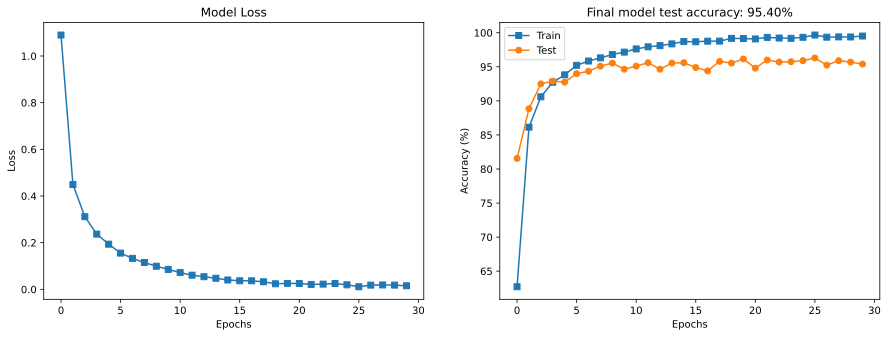

In [28]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses.cpu(), "s-")
ax[0].set_title("Model Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(trainAcc, "s-", label="Train")
ax[1].plot(testAcc, "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()